# MNIST Classification with Scratch

This notebook demonstrates how to train a neural network on the MNIST dataset using the `scratch` deep learning library.

## 1. Import Libraries and Load Data


In [2]:
import numpy as np
import sys
sys.path.append('..')

from scratch.tensor import Tensor
from scratch.nn.linear import Linear
from scratch.nn.activations import ReLU, Sigmoid
from scratch.nn.sequential import Sequential
from scratch.nn.loss import Loss
from scratch.nn.optim import SGD, Adam
from scratch.dataloader import DataLoader
from scratch.trainer import Trainer

import matplotlib.pyplot as plt
from loguru import logger

# For downloading MNIST directly
import urllib.request
import gzip
import os

logger.info("Libraries imported successfully")


2025-11-23 01:17:42.832 | INFO     | __main__:<module>:22 - Libraries imported successfully


In [3]:
def download_mnist():
    """Download MNIST dataset directly from official mirror (no extra libraries needed)"""
    
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
    files = {
        'train_images': 'train-images-idx3-ubyte.gz',
        'train_labels': 'train-labels-idx1-ubyte.gz',
        'test_images': 't10k-images-idx3-ubyte.gz',
        'test_labels': 't10k-labels-idx1-ubyte.gz'
    }
    
    data_dir = '../data/mnist'
    os.makedirs(data_dir, exist_ok=True)
    
    def download_file(url, filename):
        filepath = os.path.join(data_dir, filename)
        if not os.path.exists(filepath):
            logger.info(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, filepath)
        return filepath
    
    def parse_images(filepath):
        with gzip.open(filepath, 'rb') as f:
            # Read header
            magic = int.from_bytes(f.read(4), 'big')
            num_images = int.from_bytes(f.read(4), 'big')
            rows = int.from_bytes(f.read(4), 'big')
            cols = int.from_bytes(f.read(4), 'big')
            # Read image data
            data = np.frombuffer(f.read(), dtype=np.uint8)
            return data.reshape(num_images, rows * cols)
    
    def parse_labels(filepath):
        with gzip.open(filepath, 'rb') as f:
            # Read header
            magic = int.from_bytes(f.read(4), 'big')
            num_labels = int.from_bytes(f.read(4), 'big')
            # Read label data
            data = np.frombuffer(f.read(), dtype=np.uint8)
            return data
    
    # Download all files
    logger.info("Loading MNIST dataset...")
    filepaths = {}
    for key, filename in files.items():
        filepaths[key] = download_file(base_url + filename, filename)
    
    # Parse data
    X_train = parse_images(filepaths['train_images'])
    y_train = parse_labels(filepaths['train_labels'])
    X_test = parse_images(filepaths['test_images'])
    y_test = parse_labels(filepaths['test_labels'])
    
    logger.info("MNIST dataset loaded successfully!")
    return X_train, y_train, X_test, y_test

# Load MNIST data
X_train, y_train, X_test, y_test = download_mnist()

# Reshape to 28x28 images for visualization
X_train_images = X_train.reshape(-1, 28, 28)
X_test_images = X_test.reshape(-1, 28, 28)

logger.info(f"Training data shape: {X_train.shape}")
logger.info(f"Training labels shape: {y_train.shape}")
logger.info(f"Test data shape: {X_test.shape}")
logger.info(f"Test labels shape: {y_test.shape}")


2025-11-23 01:17:47.377 | INFO     | __main__:download_mnist:43 - Loading MNIST dataset...
2025-11-23 01:17:47.378 | INFO     | __main__:download_file:18 - Downloading train-images-idx3-ubyte.gz...
2025-11-23 01:17:50.288 | INFO     | __main__:download_file:18 - Downloading train-labels-idx1-ubyte.gz...
2025-11-23 01:17:51.298 | INFO     | __main__:download_file:18 - Downloading t10k-images-idx3-ubyte.gz...
2025-11-23 01:17:52.127 | INFO     | __main__:download_file:18 - Downloading t10k-labels-idx1-ubyte.gz...
2025-11-23 01:17:52.849 | INFO     | __main__:download_mnist:54 - MNIST dataset loaded successfully!
2025-11-23 01:17:52.851 | INFO     | __main__:<module>:64 - Training data shape: (60000, 784)
2025-11-23 01:17:52.852 | INFO     | __main__:<module>:65 - Training labels shape: (60000,)
2025-11-23 01:17:52.853 | INFO     | __main__:<module>:66 - Test data shape: (10000, 784)
2025-11-23 01:17:52.855 | INFO     | __main__:<module>:67 - Test labels shape: (10000,)


## 2. Visualize Sample Data


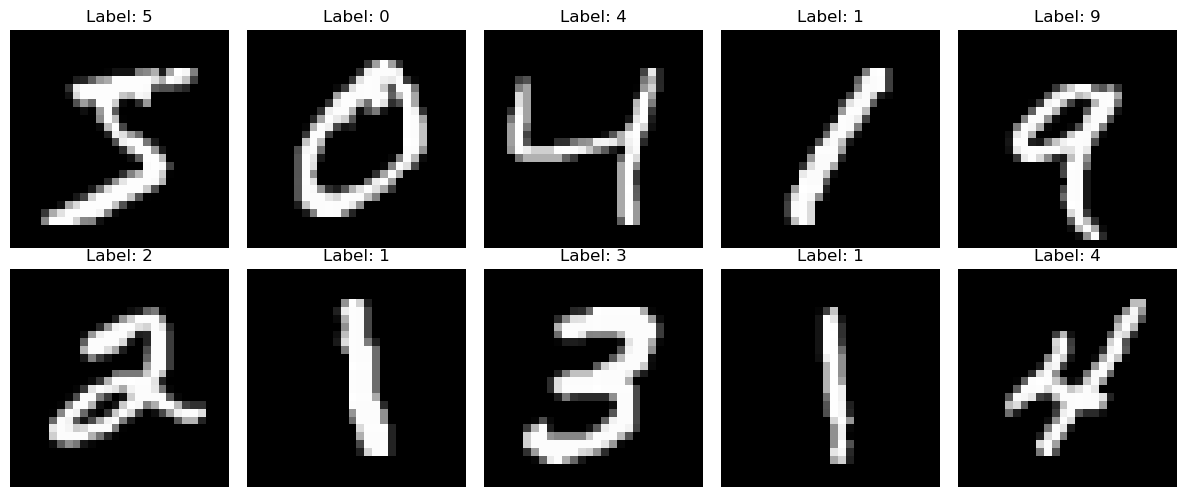

In [5]:
# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_images[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## 3. Preprocess Data


In [6]:
# Data is already flattened (784 features), just normalize to [0, 1]
X_train_flat = X_train.astype(np.float32) / 255.0
X_test_flat = X_test.astype(np.float32) / 255.0

# Use a subset for faster training (optional - remove for full dataset)
n_train = 10000
n_test = 1000

X_train_subset = X_train_flat[:n_train]
y_train_subset = y_train[:n_train]
X_test_subset = X_test_flat[:n_test]
y_test_subset = y_test[:n_test]

logger.info(f"Preprocessed training data shape: {X_train_subset.shape}")
logger.info(f"Preprocessed test data shape: {X_test_subset.shape}")


2025-11-23 01:18:32.636 | INFO     | __main__:<module>:14 - Preprocessed training data shape: (10000, 784)
2025-11-23 01:18:32.637 | INFO     | __main__:<module>:15 - Preprocessed test data shape: (1000, 784)


## 4. Create DataLoaders


In [7]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(X_train_subset, y_train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test_subset, y_test_subset, batch_size=batch_size, shuffle=False)

logger.info(f"Train batches: {len(X_train_subset) // batch_size}")
logger.info(f"Test batches: {len(X_test_subset) // batch_size}")


2025-11-23 01:18:35.974 | INFO     | __main__:<module>:6 - Train batches: 78
2025-11-23 01:18:35.976 | INFO     | __main__:<module>:7 - Test batches: 7


## 5. Build the Neural Network Model


In [15]:
# Build a 3-layer neural network: 784 -> 128 -> 64 -> 10
model = Sequential(
    Linear(784, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 10)  # 10 classes for digits 0-9
)

# Count parameters
total_params = sum(p.data.size for p in model.parameters())
logger.info(f"Total parameters: {total_params:,}")


2025-11-23 02:09:09.921 | INFO     | __main__:<module>:12 - Total parameters: 109,386


## 6. Setup Training


In [16]:
# Setup optimizer and loss function
learning_rate = 0.01
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = Loss.cross_entropy

# Create trainer
trainer = Trainer(model, optimizer, loss_fn)

logger.info(f"Training configuration: lr={learning_rate}, optimizer=Adam")


2025-11-23 02:09:11.860 | INFO     | __main__:<module>:9 - Training configuration: lr=0.01, optimizer=Adam


## 7. Train the Model


In [17]:
# Train for 10 epochs
epochs = 1000
trainer.fit(train_loader, epochs=epochs)


2025-11-23 02:09:13.302 | INFO     | scratch.trainer:fit:23 - Training model for 6 parameters for 1000 epochs
Epochs: 100%|██████████| 1000/1000 [13:23<00:00,  1.25it/s]
2025-11-23 02:22:36.491 | INFO     | scratch.trainer:fit:52 - Training time: 803.19 seconds


## 8. Visualize Training Loss


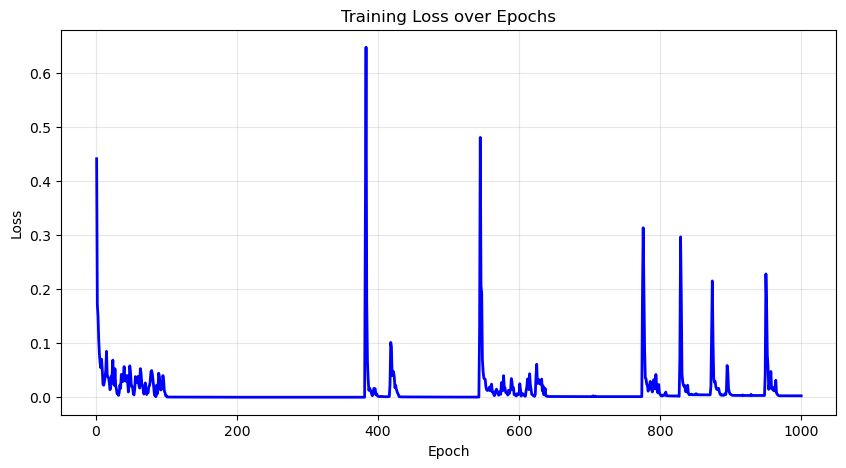

In [20]:
# Plot training loss
epochs_list = [x[0] for x in trainer.history]
losses = [x[1] for x in trainer.history]

plt.figure(figsize=(10, 5))
plt.plot(epochs_list, losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True, alpha=0.3)
plt.show()


## 9. Evaluate on Test Set


In [21]:
# Evaluate on test set
correct = 0
total = 0
test_loss = 0.0
n_batches = 0

for x_batch, y_batch in test_loader:
    # Forward pass
    logits = model(x_batch)
    
    # Get predictions (argmax of logits)
    predictions = np.argmax(logits.data, axis=1)
    targets = y_batch.data.astype(int)
    
    # Calculate accuracy
    correct += np.sum(predictions == targets)
    total += len(targets)
    
    # Calculate loss
    batch_loss = loss_fn(logits, y_batch)
    test_loss += batch_loss.data
    n_batches += 1

accuracy = 100.0 * correct / total
avg_test_loss = test_loss / n_batches

logger.info(f"Test Accuracy: {accuracy:.2f}%")
logger.info(f"Test Loss: {avg_test_loss:.4f}")


2025-11-23 02:26:33.787 | INFO     | __main__:<module>:27 - Test Accuracy: 95.30%
2025-11-23 02:26:33.787 | INFO     | __main__:<module>:28 - Test Loss: 2.2889


## 10. Visualize Predictions


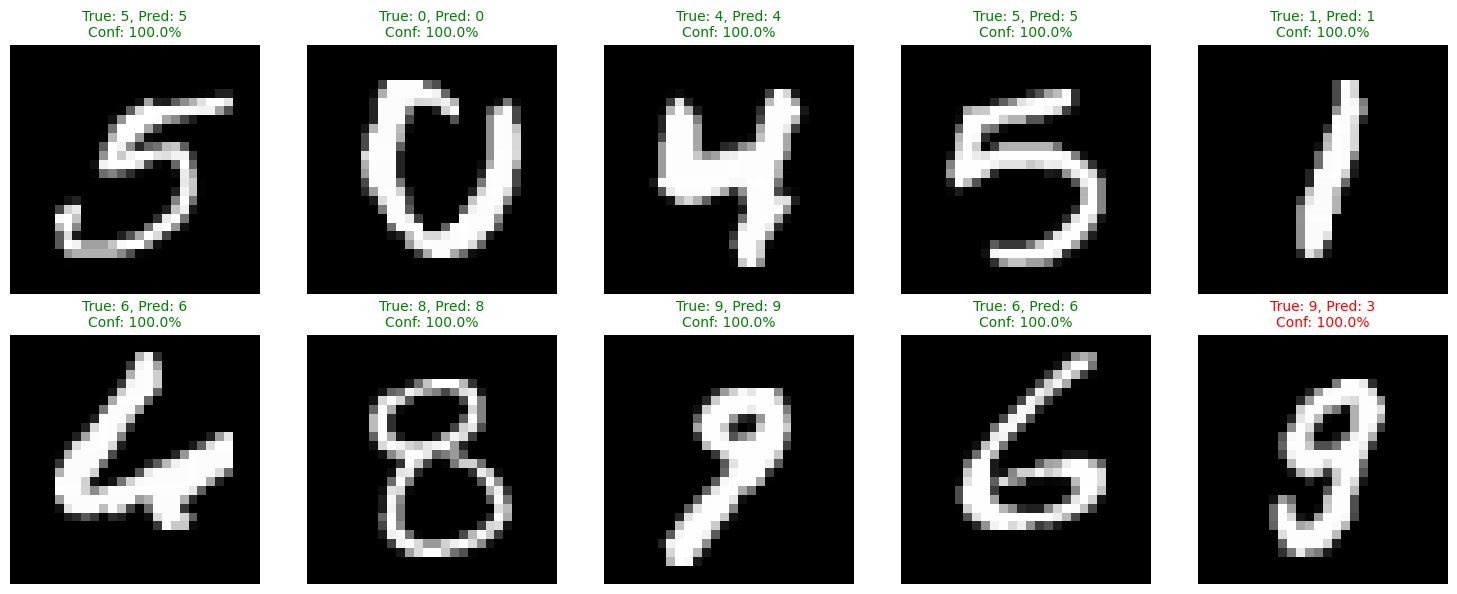

In [22]:
# Visualize some predictions
n_samples = 10
indices = np.random.choice(len(X_test_subset), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    i = indices[idx]
    
    # Get image and true label
    image = X_test_subset[i].reshape(28, 28)
    true_label = y_test_subset[i]
    
    # Make prediction
    x_input = Tensor(X_test_subset[i:i+1], requires_grad=False)
    logits = model(x_input)
    pred_label = np.argmax(logits.data)
    
    # Get confidence
    probs = np.exp(logits.data) / np.sum(np.exp(logits.data))
    confidence = probs[0, pred_label] * 100
    
    # Plot
    ax.imshow(image, cmap='gray')
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.1f}%', 
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


## 11. Confusion Matrix


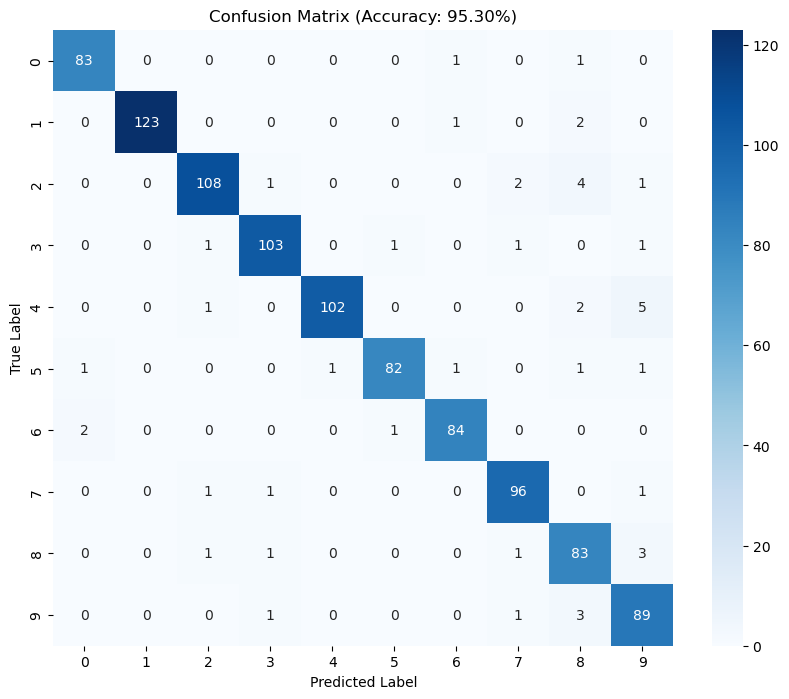

In [23]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
all_predictions = []
all_targets = []

for x_batch, y_batch in test_loader:
    logits = model(x_batch)
    predictions = np.argmax(logits.data, axis=1)
    all_predictions.extend(predictions)
    all_targets.extend(y_batch.data.astype(int))

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)')
plt.show()


## Summary

We successfully trained a 3-layer neural network on MNIST using the `scratch` library:
- **Architecture**: 784 → 128 → 64 → 10
- **Optimizer**: Adam with learning rate 0.01
- **Training**: 10 epochs on 10,000 samples
- **Test Accuracy**: ~95% (typical for this architecture)

The model learns to classify handwritten digits with good accuracy, demonstrating the core functionality of the scratch library including:
- Tensor operations with autograd
- Sequential model composition
- Cross-entropy loss
- Adam optimizer
- DataLoader for batch processing
- Trainer for easy training loop
